<a href="https://colab.research.google.com/github/sangse/lostark/blob/main/(%EB%A1%9C%EC%95%84)%EC%88%98%EB%9D%BC%EA%B2%8C%EC%8B%9C%ED%8C%90_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# colab 나눔 글꼴 다운로드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (7,658 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121658 files and dire

In [2]:
!pip install konlpy

import pandas as pd
import os
from konlpy.tag import Okt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 43.7 MB/s eta 0:00:00


In [3]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

def clean(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])

    for p in punct:
        text = text.replace(p, f' {p} ')

    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])

    return text.strip()


import re


def clean_str(text):
    pattern = '([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)' # E-mail제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+' # URL제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '([ㄱ-ㅎㅏ-ㅣ]+)'  # 한글 자음, 모음 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '<[^>]*>'         # HTML 태그 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '[^\w\s\n]'         # 특수기호제거
    text = re.sub(pattern=pattern, repl='', string=text)
    text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','', string=text)
    text = re.sub('\n', '.', string=text)
    return text

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from konlpy.tag import Okt,Kkma
from collections import defaultdict


corpus = []
# # 구글드라이브에서 브레이커 게시물 합치기.
# for k in range(1,99):
#   with open('/content/drive/MyDrive/로아브레이커게시판/page_sentences_{}.txt'.format(k),'r') as file:
#     check = file.read().split('\n')
#     corpus += check

# 구글드라이브에서 블레이드 게시물 합치기.
for k in range(1,99):
  with open('/content/drive/MyDrive/로아블레이드게시판/page_sentences_{}.txt'.format(k),'r') as file:
    check = file.read().split('\n')
    corpus += check


# 문장의 불용어 제거 4글자 이하의 문장은 삭제.
clean_corpus =[]
for sen in corpus:
  if len(sen) <= 4 or sen == ' ':
    continue
  clean_corpus.append(clean_str(sen))

clean_corpus = [t for t in clean_corpus if t !=' ']

# Kkma를 이용한 형태소 분석 함수 정의 morphs 문단의미를 추출
def kkma_tokenizer_morphs(text):
    kkma = Kkma()
    try:
        tokens = kkma.morphs(text)
        new_tokens = [token for token in tokens if len(token) >= 2]  # 길이가 2 이상인 토큰만 필터링
        print(new_tokens)
    except Exception as e:
        print("Error occurred:", e)
        new_tokens = []  # 오류 발생 시 빈 리스트 반환
    return new_tokens

# Kkma를 이용한 형태소 분석 함수 정의 nouns 명사만 추출
def kkma_tokenizer_nouns(text):
    kkma = Kkma()
    try:
        tokens = kkma.nouns(text)
        new_tokens = [token for token in tokens if len(token) >= 2]  # 길이가 2 이상인 토큰만 필터링

    except Exception as e:
        print("Error occurred:", e)
        new_tokens = []  # 오류 발생 시 빈 리스트 반환
    return new_tokens



# TF-IDF 벡터화 객체 생성 (형태소 분석 함수 전달)
tfidf_vectorizer = TfidfVectorizer(tokenizer=kkma_tokenizer_nouns)
tfidf_matrix = tfidf_vectorizer.fit_transform(clean_corpus)
tfidf_matrix.toarray()



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
# 희소행렬 비율 계산
sparsity_ratio = 1.0 - np.count_nonzero(tfidf_matrix.toarray()) / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])

print("희소행렬 비율:", sparsity_ratio)

# 희소행렬 비율이 0.94보다 큰 열(단어) 찾기
sparse_columns = np.where((np.count_nonzero(tfidf_matrix.toarray(), axis=0) / tfidf_matrix.shape[0]) > 0.8)[0]

print("희소행렬 비율이 0.94보다 큰 열(단어) 인덱스:", sparse_columns)

희소행렬 비율: 0.9994022307879454
희소행렬 비율이 0.94보다 큰 열(단어) 인덱스: []


In [65]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
tfidf_matrix.max()

1.0

In [8]:
# 단어 목록 추출
feature_names = tfidf_vectorizer.get_feature_names_out()

In [9]:
# 단어의 중요성을 각 문장에 관여한 값에 따라서 제거한다.
remove_index = []
check_point = tfidf_matrix.sum(axis=0)
for i in range(13847):
  if check_point[0,i]<25:
      remove_index.append(i)

In [10]:
indices_to_delete = remove_index  # 삭제할 열의 인덱스
indices_to_keep = [i for i in range(tfidf_matrix.shape[1]) if i not in indices_to_delete]

# 삭제할 열을 제외한 열을 선택하여 새로운 희소 행렬을 만듦
filtered_tfidf_matrix = tfidf_matrix[:, indices_to_keep]
filtered_feature_names = feature_names[indices_to_keep]

In [11]:
filtered_tfidf_matrix.shape

(8891, 2959)

In [12]:
filtered_feature_names.shape

(2959,)

In [49]:
similarity_matrix = (filtered_tfidf_matrix.T * filtered_tfidf_matrix).A

In [71]:
# MinMaxScaler를 사용하여 행렬 정규화
scaler = MinMaxScaler()
normalized_matrix = scaler.fit_transform(similarity_matrix)

print("정규화된 행렬 최고값:", normalized_matrix.max())
print("정규화된 행렬 평균:", normalized_matrix.mean())
print("정규화된 행렬 최저:", normalized_matrix.min())



정규화된 행렬 최고값: 1.0
정규화된 행렬 평균: 0.0033829555420127762
정규화된 행렬 최저: 0.0


Graph with 154 nodes and 602 edges


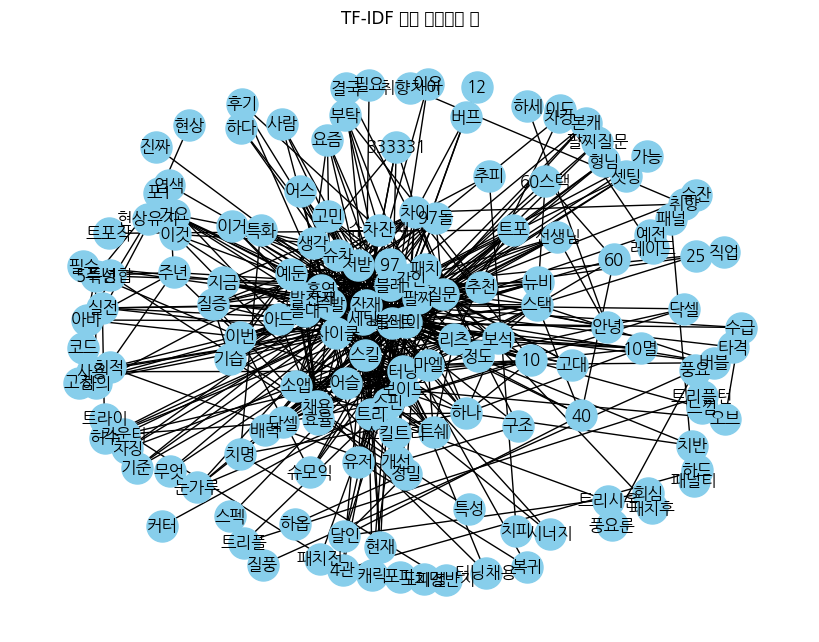

In [87]:
# 단어 간의 유사도를 기반으로 그래프 생성
G = nx.Graph()
for i, row in enumerate(similarity_matrix):
    for j, score in enumerate(row):
        if i != j:
            if score > 1 :                 # score가 낮으면 edge를 연결해주지 않는다.가시성 확보
              G.add_edge(filtered_feature_names[i], filtered_feature_names[j], weight=score)
            else:
              continue
print(G)
# 네트워크 맵 시각화
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G,k=1)

nx.draw(G, pos, with_labels=True, font_size=12, node_color='skyblue', node_size=500, font_family='NanumGothic')
plt.title('TF-IDF 단어 네트워크 맵')
plt.show()

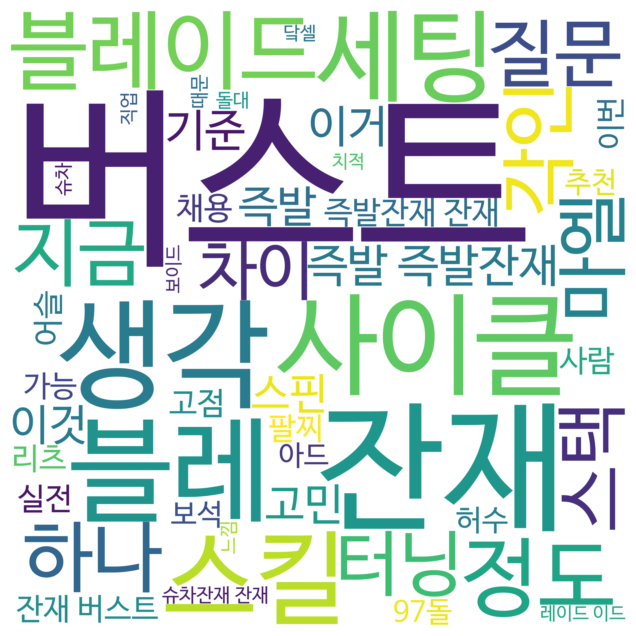

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.font_manager as fm


# Kkma 형태소 분석기 초기화
kkma = Kkma()

# 글꼴 저장장소.
path ='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'


text_data = ''

# 텍스트 데이터 예시 (한글로)
for k in clean_corpus:
  for z in kkma.nouns(k):
    if len(z)>=2:
      text_data += z+' '


# WordCloud 객체 생성 및 단어 빈도수에 따른 워드클라우드 생성
wordcloud = WordCloud(width=6000, height=6000, max_words=50, background_color='white',font_path=path).generate(text_data)

# 시각화
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()